## Goodreads Book Recommender

#### Introduction

This notebook generates book recommendations using two methods: collabortive filtering based on reader similarity and collaborative filtering based on predicted book ratings. The former uses KNN while the latter uses two forms of matrix factorization - first by singular value decomposition (SVD) and next by gradient descent using alternating least squares (ALS). 

Book and user ratings data come from the [Goodreads Book Graph Datasets](https://github.com/MengtingWan/goodreads]) produced by Mengting Wan, Rishabh Misra, Ndapa Nakashole, and Julian McAuley at UCSD. It has been imported, cleaned, and preprocessed in [00_prep_goodreads_data.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/00_prep_goodreads_data.ipynb). Genres, which are important for filtering recommendations but missing from the UCSD dataset, are inferred by topic modeling via latent dirichlet allocation (LDA) on book descriptions in [01_infer_genres.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/01_infer_genres.ipynb).

The target reader, for whom recommendations are being made in this notebook, is myself. To substitute your own Goodreads data and get personalized recommendations, go to the [Import/Export page](https://www.goodreads.com/review/import) on your Goodreads profile, download your books, and save as ```./data/goodreads_library_export.csv``` 

#### Contents

[Part 0: Preprocessing](#part-0-preprocessing)
- [0.1 - Load and Prepare Data](#01---load-and-prepare-data)
- [0.1 - Write Functions to Process Recommendations](#02---write-functions-to-process-recommendations)

[Part 1: Collaborative Filtering Based on Reader Similarity with KNN](#part-1---collaborative-filtering-based-on-reader-similarity-with-knn)
- [1.1 - Find Similar Readers](#11---find-similar-readers)
- [1.2 - Generate Recommendations](#12---generate-recommendations)


[Part 2: Collaborative Filtering Based on Predicted Ratings with Matrix Factorization](#part-2---collaborative-filtering-based-on-predicted-ratings-with-matrix-factorization)
- [2.1 - Factorize User-Rating Matrix with SVD](#21---factorize-user-rating-matrix-with-svd)
- [2.2 - Generate Recommendations by Predicting Ratings](#22---generate-recommendations-by-predicting-ratings)
- [2.3 - Matrix Factorization with Gradient Descent](#23-matrix-factorization-with-gradient-descent)

## Part 0: Preprocessing

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds

In [66]:
# Set global variable of "sparse" or "dense"
# "sparse" will have user-item matrix with all books, "dense" only those in df_books
SPARSITY = "dense" 

# Choose K for small med and large neighborhoods
SM, MD, LG = 200, 750, 2000

### 0.1 - Load and Prepare Data

In [67]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres, how="left", on="book_id")

# Filter out kids books
df_books = df_books[df_books.loc[:,"children":"comic"].sum(axis=1) < 2]

In [68]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [98]:
# Create df_reviews that is less sparse than original
if SPARSITY == "dense":
    in_df_books = book_index["book_id"].isin(df_books["book_id"])
    book_index = book_index[in_df_books].reset_index().drop("index", axis=1)
    df_reviews = df_reviews[:, in_df_books]
print(f"User-Item Matrix: {df_reviews.shape[0]:,} readers by {df_reviews.shape[1]:,} books")    

User-Item Matrix: 245,120 readers by 287,701 books


In [70]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# Reformat to fit sparse matrix
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="left", on="book_id", suffixes=["_mb","_dfb"]
            )
my_books_id_match = my_books_1[~my_books_1["title_dfb"].isna()]
print(f"Matching on book_id: {my_books_id_match.shape[0]}")

my_books_2 = pd.merge(
    my_books_1[my_books_1["title_dfb"].isna()], df_books[["book_id", "title"]], 
    how="left", left_on="title_mb", right_on="title", suffixes=["_mb","_dfb"]
    )
my_books_match_on_title = my_books_2[~my_books_2["title"].isna()]
print(f"Matching on title: {my_books_match_on_title.shape[0]}")

my_books_id_match = my_books_id_match[["book_id", "rating", "title_dfb"]]\
                        .rename(columns={"title_dfb":"title"})
my_books_match_on_title = my_books_match_on_title[["book_id_dfb", "rating", "title"]]\
                        .rename(columns={"book_id_dfb":"book_id"})

my_books_3 = pd.concat([my_books_id_match, my_books_match_on_title])
my_books_3 = my_books_3.drop_duplicates(subset="book_id")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])
df_reviews = sparse.csr_matrix(df_reviews)

# Normalize reviews within readers for KNN
norm = Normalizer()
df_reviews_norm = norm.fit_transform(df_reviews) 

Target reader ratings: 168
Matching on book_id: 28
Matching on title: 68
Total matches: 96, 57.14% of total


In [71]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Write Functions to Process Recommendations

In [72]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#(?:[2-9]|[1-9]\d+)"
    regex2 = r"Vol. (?:[0-9]|[1-9]\d+)"
    regex3 = r"Volume (?:[0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex3)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings, dists

In [73]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.9, min_ratings=400, n_recs=15, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))    
    
    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g")\
            .sort_values(by="predicted_rating", ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(50))

        print(gs)
        display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [74]:
# Functions to show top rated and most popular among similar readers
def neighbors_most_popular(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):
    
    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

    popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / 
                                                    others["uid"].nunique()).map('{:.1%}'.format)
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
                
        writer.close

    return popular_recs[["title","avg_rating","ratings_count","year","percent_similar_users_read","url"]]


def neighbors_top_rated(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):

    highest_rated_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .nlargest(n, "avg_rating").drop(columns="book_id")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
                
        writer.close

    return highest_rated_recs

In [75]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):

    # Get genre rankings for target and neighbors
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"target"})
    target_genre_ranking = target_genre_ranking.div(target_genre_ranking.sum(axis=0), axis=1)

    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"neighbor"})
    neighbor_genre_ranking = neighbor_genre_ranking.div(neighbor_genre_ranking.sum(axis=0), axis=1)

    genre_rankings = pd.merge(
            target_genre_ranking, neighbor_genre_ranking, left_index=True, right_index=True
            ).reset_index()

    # Plot target genre pref
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='target',
        s=150,
        edgecolors='black',
        linewidths = 0.75,
        label='Target Reader',
        zorder=2,
        )

    # Plot neighbors genre pref
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='neighbor',
        label='Similar Readers',
        s=150,
        zorder=3
        )

    # Iterate through each genre and plot line connecting 2 points
    for ind in list(genre_rankings['index']):
    
        # Plot line connecting points
        plt.plot([genre_rankings[genre_rankings['index']==ind]['target'],
                    genre_rankings[genre_rankings['index']==ind]['neighbor']],
                    [ind, ind],
                    color='#565A5C',
                    alpha=0.9,                    
                    linestyle=(0, (1,1)),
                    linewidth=2.5,
                    zorder=1
                    )

    # Set chart details
    plt.legend(bbox_to_anchor=(1,1), loc="upper left", borderpad=1)
    ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
    ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
    plt.xlabel("Genre preference")
    plt.ylabel(None)
    plt.title('Top Genres for Target Reader and Similar Readers', fontsize=14)
    plt.show()

## Part 1 - Collaborative Filtering Based on Reader Similarity with KNN

In this section, we use K-Nearest Neighbors (KNN) to find the readers most similar to our target reader. Each reader's ratings on all books in the dataset are encoded as vectors where unread books are given a value of 0. We use cosine similarity to find the users whose ratings are most similar to the target and then filter among their books to find the most popular and highest rated.

### 1.1 - Find Similar Readers

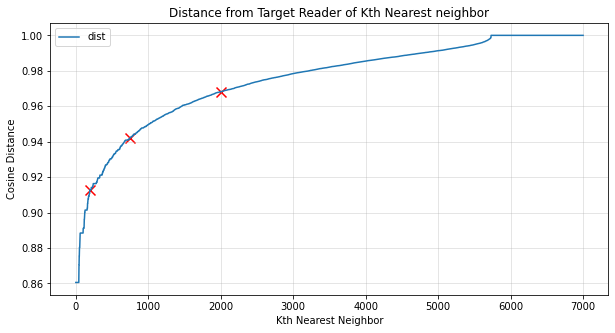

In [76]:
# Take a very large neighborhood to see how reader similarity decreases with K
n, t, dists = find_neighbors(10000, target, df_reviews_norm, book_index, df_books)

# Plot distance by kth closest neighbor
fig, ax = plt.subplots(figsize=(10,5))
pd.DataFrame(dists.T).rename(columns={0:"dist"})[1:7000].plot(ax=ax)
plt.title("Distance from Target Reader of Kth Nearest neighbor")
plt.xlabel("Kth Nearest Neighbor")
plt.ylabel("Cosine Distance")
ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
plt.scatter(SM, dists[0,SM], color="red", marker="x", s=100)
plt.scatter(MD, dists[0,MD], color="red", marker="x", s=100)
plt.scatter(LG, dists[0,LG], color="red", marker="x", s=100)
plt.show()

In [99]:
# Perform KNN on user rating matrix
sm_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                        SM, target, df_reviews, book_index, df_books)

# Find med number of similar users than before to get broader pool of potentially relevant books
med_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                    MD, target, df_reviews, book_index, df_books)

# Find larger number of similar users 
lg_neighborhoodhood_ratings, target_user_ratings, d = find_neighbors(
                                                        LG, target, df_reviews, book_index, df_books)

print(f"Small neighborhood contains {sm_neighborhood_ratings['book_index'].nunique():,} books")
print(f"Medium neighborhood contains {med_neighborhood_ratings['book_index'].nunique():,} books")
print(f"Large neighborhood contains {lg_neighborhoodhood_ratings['book_index'].nunique():,} books")

Small neighborhood contains 232 books
Medium neighborhood contains 1,735 books
Large neighborhood contains 10,490 books


<a id='Part1.2'></a>
### 1.2 - Generate Recommendations

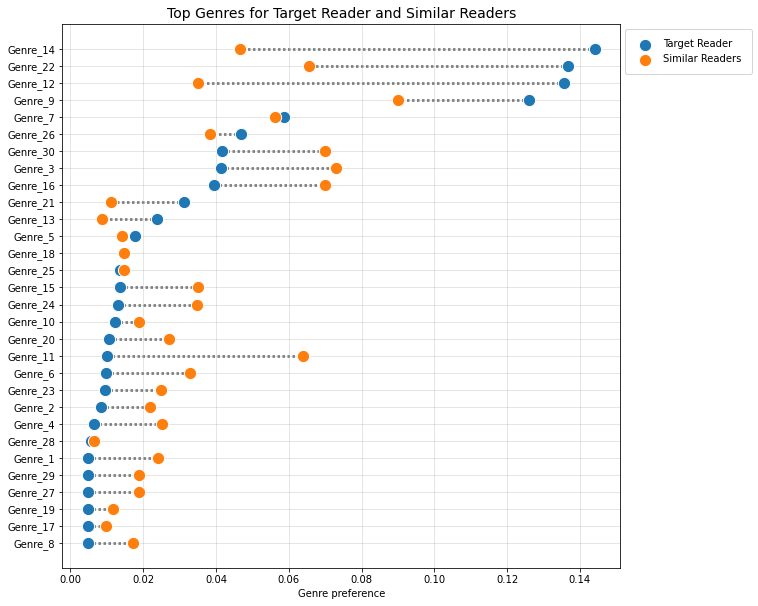

In [78]:
# Show top genres
plot_top_genres(sm_neighborhood_ratings, target_user_ratings)

In [79]:
# View most popular books among neighbors
neighbors_most_popular(sm_neighborhood_ratings, 15, min_ratings=400, write_to_excel=False)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
110,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,2.5%,https://www.goodreads.com/book/show/13453029-w...
103,The Yellow Wall-Paper,4.11,45971.0,1996,1.7%,https://www.goodreads.com/book/show/286957.The...
8,Anything You Can Do,3.98,7816.0,2017,1.7%,https://www.goodreads.com/book/show/34044126-a...
9,Assata: An Autobiography,4.47,11057.0,1999,0.8%,https://www.goodreads.com/book/show/100322.Assata
82,The Girl with Seven Names: A North Korean Defe...,4.45,8293.0,2015,0.8%,https://www.goodreads.com/book/show/25362017-t...
28,"Deep: Freediving, Renegade Science, and What t...",4.40,1144.0,2014,0.8%,https://www.goodreads.com/book/show/18222705-deep
78,The Complete Conversations with God,4.38,3395.0,1998,0.8%,https://www.goodreads.com/book/show/15016.The_...
3,A Farewell to Mars: An Evangelical Pastor's Jo...,4.35,573.0,2014,0.8%,https://www.goodreads.com/book/show/18281678-a...
10,Auschwitz and After,4.35,758.0,1997,0.8%,https://www.goodreads.com/book/show/339757.Aus...
20,Bobby Singer's Guide to Hunting,4.32,1942.0,2011,0.8%,https://www.goodreads.com/book/show/11804728-b...


In [80]:
# View highest rated books among similar readers
neighbors_top_rated(sm_neighborhood_ratings, 15, min_ratings=400, write_to_excel=False)

,title,avg_rating,ratings_count,year,url
9,Assata: An Autobiography,4.47,11057.0,1999,https://www.goodreads.com/book/show/100322.Assata
82,The Girl with Seven Names: A North Korean Defe...,4.45,8293.0,2015,https://www.goodreads.com/book/show/25362017-t...
28,"Deep: Freediving, Renegade Science, and What t...",4.40,1144.0,2014,https://www.goodreads.com/book/show/18222705-deep
78,The Complete Conversations with God,4.38,3395.0,1998,https://www.goodreads.com/book/show/15016.The_...
3,A Farewell to Mars: An Evangelical Pastor's Jo...,4.35,573.0,2014,https://www.goodreads.com/book/show/18281678-a...
10,Auschwitz and After,4.35,758.0,1997,https://www.goodreads.com/book/show/339757.Aus...
20,Bobby Singer's Guide to Hunting,4.32,1942.0,2011,https://www.goodreads.com/book/show/11804728-b...
60,"Red Sister (Book of the Ancestor, #1)",4.32,5784.0,2017,https://www.goodreads.com/book/show/25895524-r...
53,New Seeds of Contemplation,4.31,913.0,2007,https://www.goodreads.com/book/show/1145854.Ne...
63,"Scythe (Arc of a Scythe, #1)",4.30,13000.0,2016,https://www.goodreads.com/book/show/28954189-s...


In [81]:
# View highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, 
    others=sm_neighborhood_ratings, 
    how="KNN", 
    whose_genres="target", 
    n_genres=5, 
    min_score=3.9, 
    min_ratings=400, 
    n_recs=15,
    write_to_excel=False
)

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
6,Narconomics: How to Run a Drug Cartel,4.14,2268.0,https://www.goodreads.com/book/show/25159062-n...
8,Shades of Grey,4.14,23122.0,https://www.goodreads.com/book/show/2113260.Sh...
2,Capital in the Twenty-First Century,4.02,13494.0,https://www.goodreads.com/book/show/18736925-c...
3,Don't Think of an Elephant! Know Your Values a...,3.96,3360.0,https://www.goodreads.com/book/show/13455.Don_...
7,One Child: The Story of China's Most Radical E...,3.92,1108.0,https://www.goodreads.com/book/show/23719361-o...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
7,"Notes from Underground, White Nights, The Drea...",4.17,66680.0,https://www.goodreads.com/book/show/17876.Note...
3,Invisible Planets: Contemporary Chinese Scienc...,4.13,650.0,https://www.goodreads.com/book/show/28220730-i...
10,The Dune Encyclopedia,4.08,3343.0,https://www.goodreads.com/book/show/870294.The...
9,Surprised by Scripture: Engaging Contemporary ...,4.06,618.0,https://www.goodreads.com/book/show/18651961-s...
16,When Elephants Weep: The Emotional Lives of An...,4.04,3744.0,https://www.goodreads.com/book/show/167224.Whe...
2,How to Read a Book: The Classic Guide to Intel...,4.00,9478.0,https://www.goodreads.com/book/show/567610.How...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
1,Dragon's Egg,4.14,4328.0,https://www.goodreads.com/book/show/263466.Dra...


_____

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
0,Assata: An Autobiography,4.47,11057.0,https://www.goodreads.com/book/show/100322.Assata
14,The Girl with Seven Names: A North Korean Defe...,4.45,8293.0,https://www.goodreads.com/book/show/25362017-t...
1,Auschwitz and After,4.35,758.0,https://www.goodreads.com/book/show/339757.Aus...
7,"Dear Leader: Poet, Spy, Escapee—A Look Inside ...",4.29,2732.0,https://www.goodreads.com/book/show/20736640-d...
18,We Wish to Inform You That Tomorrow We Will Be...,4.29,19564.0,https://www.goodreads.com/book/show/11472.We_W...
13,Stars Between the Sun and Moon: One Woman's Li...,4.16,451.0,https://www.goodreads.com/book/show/25420166-s...
5,Clementine: The Life of Mrs. Winston Churchill,4.08,1042.0,https://www.goodreads.com/book/show/24611873-c...
6,Curfewed Night,3.94,1820.0,https://www.goodreads.com/book/show/6047138-cu...
11,No One Cares About Crazy People: The Chaos and...,3.92,834.0,https://www.goodreads.com/book/show/30363776-n...
3,Blue Pills: A Positive Love Story,3.91,3154.0,https://www.goodreads.com/book/show/1390442.Bl...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,ratings_count,url
10,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
4,It Gets Worse: A Collection of Essays,4.27,520.0,https://www.goodreads.com/book/show/27276226-i...
13,You Deserve a Drink: Boozy Misadventures and T...,4.21,4938.0,https://www.goodreads.com/book/show/23281915-y...
11,The Real James Herriot: A Memoir of My Father,4.17,3791.0,https://www.goodreads.com/book/show/38737.The_...
1,Dorothy Parker: What Fresh Hell Is This?,4.11,2429.0,https://www.goodreads.com/book/show/181120.Dor...
12,The Unpersuadables: Adventures with the Enemie...,4.00,580.0,https://www.goodreads.com/book/show/18114379-t...
0,Bad Feminist,3.91,43988.0,https://www.goodreads.com/book/show/18813642-b...


_____



## Part 2 - Collaborative Filtering Based on Predicted Ratings with Matrix Factorization

In sections [2.1](#21---factorize-user-rating-matrix-with-svd) and [2.2](#22---generate-recommendations-by-predicting-ratings) we use singular value decomposition (SVD) to factorize the user-rating matrix generated from the 1500 most similar readers to the target reader, as determined by KNN. SVD decomposes our $m * n$ user-rating matrix $R$ into 3 smaller matrices: $$R = U \Sigma \mathbf{V}^\top$$ where $U$, the left singular vectors, represents an $m * k$ embedding space of user features and $\mathbf{V}^\top$, the right singular vectors, represents a $k * n$ embedding of book features. Estimated ratings come from multiplying the decomposed matrices together to approximate $R$. 

The advantage of SVD is its simplicity and computational efficiency. The disadvantage is that it requires unseen ratings to be encoded as 0 and therefore all predicted ratings on unread books are near zero rather than more realistic values. 

-----

In section [2.3](#23-matrix-factorization-with-gradient-descent) we use gradient descent to train user and book embedding matrices $P$ and $Q$. We minimize the loss function: $$L = (r_{ij} - \sum_{k=1}^{K} p_{ik}q_{kj})^2 + \frac{\beta}{2}\sum_{k=1}^{K}(||P||^2 + ||Q||^2)$$ for all $r_{ij} > 0$ using alternating least squares. After training, we reconstruct $R$ matrix by multiplyting $P * Q$. See [here](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/) for a helpful description of th math.

The advantage of gradient descent is that we can train the model on nonzero ratings (i.e. only for books users have actually rated) and apply it to unread books, which yields realistic rating predictions. The downside is that it is computationally very expensive. Larger user-raing $R$ matrices have exponentially more values than smaller ones, so there is a limit to how many nearest neighbors we can use to generate the full set of book ratings to consider. 

#### 2.1 - Factorize User-Rating Matrix with SVD

In [82]:
# Choose neighborhood size for SVD
svd_neighborhood_ratings = lg_neighborhoodhood_ratings

In [100]:
# Get unique users and books to slice df_reviews
svd_neighbor_index = svd_neighborhood_ratings["uid"].unique()
svd_neighbor_index = np.append(svd_neighbor_index, target)
svd_neighbor_book_index = svd_neighborhood_ratings["book_index"].unique()
svd_neighbor_book_index = np.append(svd_neighbor_book_index, target_user_ratings["book_index"].unique())

print(f"Neighborhood contains {svd_neighbor_book_index.shape[0]:,} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, svd_neighbor_book_index]
R = R[svd_neighbor_index, :]

Neighborhood contains 10,586 books


In [84]:
# Decompose user ratings matrix R with SVD
U, sigma, Vt = svds(R, k=50)
sigma = np.diag(sigma)

# Convert to sparse matrix
U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

#### 2.2 - Generate Recommendations by Predicting Ratings

In [85]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(
                all_user_predicted_ratings.toarray(), columns=svd_neighbor_book_index, index=svd_neighbor_index
                ).reset_index()

In [86]:
# Get top recs from predictions
def get_recs(preds, target_reader, book_ind, books, write_to_excel=False):
    
    target_pred_books = preds[preds["index"] == target_reader].columns[1:]
    target_pred_ratings = preds[preds["index"] == target_reader].values[0][1:]

    # Put into df with relevant info from df_books
    top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                    .sort_values(by="predicted_rating", ascending=False)\
                    .merge(book_ind.reset_index(), left_on="book_index", right_on="index")\
                    .merge(
                        books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                        on="book_id"
                    )\
                    .drop(columns=["index", "book_id"])

    # Filter out already read books
    top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
    top_preds.drop(["book_index"], axis=1, inplace=True)

    if write_to_excel == True:
        # Write to excel
        path = wd + "/data/book_recs.xlsx"
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        writer.close

    return top_preds

In [87]:
# View books with highest target user predicted score
top_preds = get_recs(df_preds, target, book_index, df_books, write_to_excel=False)
top_preds[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 4.15 & ratings_count > 750").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
100,How Not to Die: Discover the Foods Scientifica...,4.53,0.234609,4467.0,2015,https://www.goodreads.com/book/show/25663961-h...
102,I Feel Sick #1,4.17,0.233853,2104.0,2000,https://www.goodreads.com/book/show/1375054.I_...
103,Labyrinths: Selected Stories and Other Writings,4.46,0.230087,20553.0,1964,https://www.goodreads.com/book/show/17717.Laby...
111,Collected Stories,4.18,0.187082,5756.0,2008,https://www.goodreads.com/book/show/759.Collec...
115,The Overcoat and Other Tales of Good and Evil,4.26,0.187082,1281.0,1965,https://www.goodreads.com/book/show/537072.The...
120,The Manuscript Found in Saragossa,4.17,0.187082,1398.0,1996,https://www.goodreads.com/book/show/93180.The_...
129,Unlimited Power : The New Science Of Personal ...,4.21,0.173497,19373.0,1986,https://www.goodreads.com/book/show/8676.Unlim...
130,Animal Farm / 1984,4.26,0.172551,120269.0,2003,https://www.goodreads.com/book/show/5472.Anima...
141,Economics in One Lesson: The Shortest & Surest...,4.22,0.162247,9336.0,1979,https://www.goodreads.com/book/show/3028.Econo...
142,Beneath a Scarlet Sky,4.43,0.162065,16505.0,2017,https://www.goodreads.com/book/show/32487617-b...


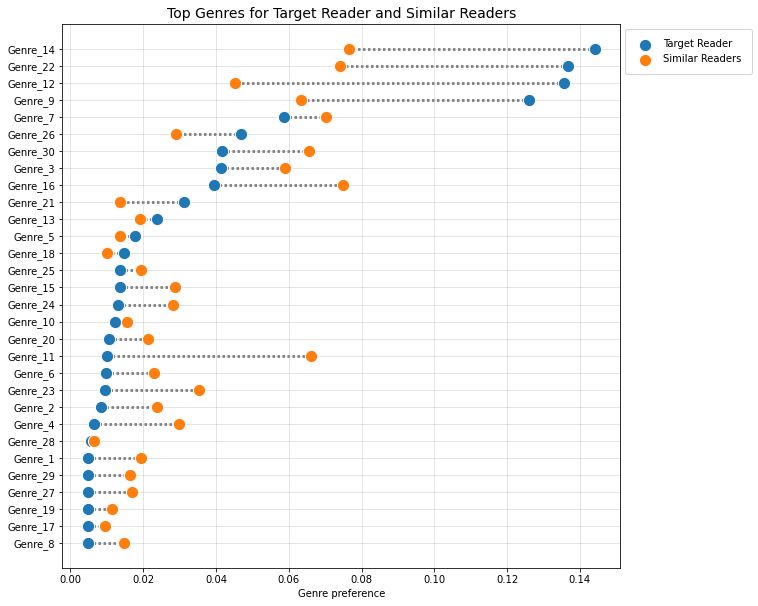

In [88]:
# Show top genres
plot_top_genres(svd_neighborhood_ratings, target_user_ratings)

In [89]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(svd_neighborhood_ratings, 50, min_ratings=400, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
3639,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,2002,2.1%,https://www.goodreads.com/book/show/5043.The_P...
3248,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,2013,2.0%,https://www.goodreads.com/book/show/15819028-t...
380,Bad Feminist,3.91,43988.0,2014,2.0%,https://www.goodreads.com/book/show/18813642-b...
1966,My Brilliant Friend (The Neapolitan Novels #1),3.89,66369.0,2012,1.3%,https://www.goodreads.com/book/show/13586707-m...
4406,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,1.2%,https://www.goodreads.com/book/show/13453029-w...
2385,"Rich Dad, Poor Dad",3.96,164543.0,2007,1.2%,https://www.goodreads.com/book/show/69571.Rich...
305,"Angels & Demons (Robert Langdon, #1)",3.86,2046499.0,2006,1.2%,https://www.goodreads.com/book/show/960.Angels...
2538,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,1.0%,https://www.goodreads.com/book/show/27220736-s...
1487,"I, Robot (Robot #0.1)",4.17,201196.0,2004,1.0%,https://www.goodreads.com/book/show/41804.I_Robot
3571,The New Jim Crow: Mass Incarceration in the Ag...,4.49,24694.0,2010,0.9%,https://www.goodreads.com/book/show/6792458-th...


In [90]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(svd_neighborhood_ratings, min_ratings=400, write_to_excel=False)
top_rated.head(15)

,title,avg_rating,ratings_count,year,url
3376,The Journey Within: A Modern Guide to the Anci...,4.87,971.0,2016,https://www.goodreads.com/book/show/15817111-t...
1847,Mark of the Lion Trilogy,4.76,9189.0,1998,https://www.goodreads.com/book/show/95602.Mark...
2444,Saga: Book One,4.70,4201.0,2014,https://www.goodreads.com/book/show/22078240-saga
815,Dear Evan Hansen,4.70,563.0,2017,https://www.goodreads.com/book/show/34381137-d...
2445,Saga: Book Two,4.68,866.0,2017,https://www.goodreads.com/book/show/32926680-saga
1460,I Dissent: Ruth Bader Ginsburg Makes Her Mark,4.67,1665.0,2016,https://www.goodreads.com/book/show/28210996-i...
72,A Game of Thrones: The Book of Ice and Fire RP...,4.67,7486.0,2004,https://www.goodreads.com/book/show/4700482-a-...
1470,I Will Lead You Along: The Life of Henry B. Ey...,4.67,434.0,2013,https://www.goodreads.com/book/show/18781290-i...
3311,The Holy Bible: English Standard Version,4.66,18613.0,2007,https://www.goodreads.com/book/show/5883777-th...
3196,The Food Lab: Better Home Cooking Through Science,4.65,3005.0,2015,https://www.goodreads.com/book/show/24861842-t...


In [91]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    svd_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=5, 
    min_score=4.0, 
    min_ratings=400, 
    n_recs=20,
    write_to_excel=False
)

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
109,Poorly Made in China: An Insider's Account of ...,4.04,1138.0,https://www.goodreads.com/book/show/5116296-po...
110,American Prometheus: The Triumph and Tragedy o...,4.15,8311.0,https://www.goodreads.com/book/show/80571.Amer...
130,Animal Farm / 1984,4.26,120269.0,https://www.goodreads.com/book/show/5472.Anima...
140,When Life Nearly Died: The Greatest Mass Extin...,4.12,708.0,https://www.goodreads.com/book/show/616394.Whe...
141,Economics in One Lesson: The Shortest & Surest...,4.22,9336.0,https://www.goodreads.com/book/show/3028.Econo...
178,Conversation in the Cathedral,4.32,3331.0,https://www.goodreads.com/book/show/53970.Conv...
202,The Invisible Bridge: The Fall of Nixon and th...,4.12,1325.0,https://www.goodreads.com/book/show/20694952-t...
221,Tears We Cannot Stop: A Sermon to White America,4.34,2498.0,https://www.goodreads.com/book/show/31421117-t...
224,"Family of Secrets: The Bush Dynasty, the Power...",4.07,556.0,https://www.goodreads.com/book/show/4274612-fa...
226,Before the Storm: Barry Goldwater and the Unma...,4.19,1852.0,https://www.goodreads.com/book/show/138349.Bef...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
103,Labyrinths: Selected Stories and Other Writings,4.46,20553.0,https://www.goodreads.com/book/show/17717.Laby...
111,Collected Stories,4.18,5756.0,https://www.goodreads.com/book/show/759.Collec...
184,Fiasco,4.11,1811.0,https://www.goodreads.com/book/show/28766.Fiasco
215,Oxygen: The Molecule That Made the World,4.10,1464.0,https://www.goodreads.com/book/show/291056.Oxygen
219,Feathers: The Evolution of a Natural Miracle,4.03,1056.0,https://www.goodreads.com/book/show/9634191-fe...
248,How to Read the Bible for All Its Worth,4.10,7542.0,https://www.goodreads.com/book/show/24109.How_...
255,How We Die: Reflections of Life's Final Chapter,4.04,5375.0,https://www.goodreads.com/book/show/49286.How_...
274,The Worldly Philosophers,4.12,4590.0,https://www.goodreads.com/book/show/82120.The_...
326,In Search of the Multiverse,4.05,789.0,https://www.goodreads.com/book/show/6881432-in...
397,Van Gogh: The Life,4.09,14046.0,https://www.goodreads.com/book/show/10677213-v...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
119,Schrödinger's Cat Trilogy,4.07,3983.0,https://www.goodreads.com/book/show/62567.Schr...
125,"We Are Legion (We Are Bob) (Bobiverse, #1)",4.30,609.0,https://www.goodreads.com/book/show/32603222-w...
258,The Enigma of Amigara Fault,4.23,1855.0,https://www.goodreads.com/book/show/18129124-t...
280,"I, Robot (Robot, #0.1)",4.17,2235.0,https://www.goodreads.com/book/show/76684.I_Robot
286,Heir to the Empire (Star Wars: The Thrawn Tril...,4.12,51211.0,https://www.goodreads.com/book/show/216443.Hei...
467,"The Walking Dead, Compendium 1",4.43,58434.0,https://www.goodreads.com/book/show/6465707-th...
499,Convict Conditioning: How to Bust Free of All ...,4.13,1419.0,https://www.goodreads.com/book/show/7305111-co...
606,"Fear the Sky (The Fear Saga, #1)",4.05,3997.0,https://www.goodreads.com/book/show/22171697-f...
625,"Until Midnight (Alienated, #1.5)",4.05,1771.0,https://www.goodreads.com/book/show/22614886-u...
742,"Linesman (Linesman, #1)",4.06,1130.0,https://www.goodreads.com/book/show/23604332-l...


_____

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
142,Beneath a Scarlet Sky,4.43,16505.0,https://www.goodreads.com/book/show/32487617-b...
236,Miracle in the Andes,4.22,11354.0,https://www.goodreads.com/book/show/454236.Mir...
271,A. Lincoln,4.22,9160.0,https://www.goodreads.com/book/show/4059448-a-...
273,The Complete Poems,4.05,7337.0,https://www.goodreads.com/book/show/223394.The...
285,Desert Solitaire,4.22,28380.0,https://www.goodreads.com/book/show/214614.Des...
357,"Forgotten Ally: China's World War II, 1937-1945",4.08,446.0,https://www.goodreads.com/book/show/20256718-f...
364,Wenjack,4.31,3096.0,https://www.goodreads.com/book/show/30079906-w...
402,When Pride Still Mattered: A Life Of Vince Lom...,4.18,6019.0,https://www.goodreads.com/book/show/215297.Whe...
403,"A Suitable Boy (A Suitable Boy, #1)",4.10,34468.0,https://www.goodreads.com/book/show/50365.A_Su...
411,My Share of the Task: A Memoir,4.10,889.0,https://www.goodreads.com/book/show/13588403-m...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,ratings_count,url
144,Strange Stones: Dispatches from East and West,4.12,830.0,https://www.goodreads.com/book/show/15818376-s...
164,A Work in Progress,4.35,14878.0,https://www.goodreads.com/book/show/22886113-a...
174,Cool Gray City of Love: 49 Views of San Francisco,4.22,848.0,https://www.goodreads.com/book/show/16059425-c...
253,Dust Tracks on a Road,4.11,4215.0,https://www.goodreads.com/book/show/58399.Dust...
257,Thanking the Monkey: Rethinking the Way We Tre...,4.13,462.0,https://www.goodreads.com/book/show/2604604-th...
282,Hitchcock,4.48,3515.0,https://www.goodreads.com/book/show/393601.Hit...
642,"Harry, a History: The True Story of a Boy Wiza...",4.09,12587.0,https://www.goodreads.com/book/show/3130430-ha...
753,The War for Late Night: When Leno Went Early a...,4.01,3367.0,https://www.goodreads.com/book/show/8201411-th...
885,The Quotable Slayer,4.18,564.0,https://www.goodreads.com/book/show/836177.The...
923,"Tales of the City (Tales of the City, #1)",4.06,1141.0,https://www.goodreads.com/book/show/413729.Tal...


_____



### 2.3 Matrix Factorization with Gradient Descent

In [92]:
# Choose neighborhood size for GD
gd_neighborhoodhood_ratings = med_neighborhood_ratings

In [101]:
# Get unique users and books to slice df_reviews
gd_neighborhood_index = gd_neighborhoodhood_ratings["uid"].unique()
gd_neighborhood_index = np.append(gd_neighborhood_index, target)
gd_neighborhood_book_index = gd_neighborhoodhood_ratings["book_index"].unique()
gd_neighborhood_book_index = np.append(gd_neighborhood_book_index, target_user_ratings["book_index"].unique())
print(f"Neighborhood contains {gd_neighborhood_book_index.shape[0]:,} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, gd_neighborhood_book_index]
R = R[gd_neighborhood_index, :]
R = R.toarray()

Neighborhood contains 1,831 books


In [94]:
# Function to train embedding matrices using alternating least squares (ALS) and make predictions 
def matrix_factorization(R, k_components=5, steps=4000, lr=0.0002, beta=0.03, decay=True, verbose=0):
    """
    Uses gradient descent to train matrix factorization algorithm

    Args:
        R: Utility matrix of user item ratings         
        k: Number of latent features
        steps: Number of epochs to run training
        lr: Learning rate
        beta: Regularization strength
        verbose: Prints updates if 1

    Returns:
        Predictions, User Embeddings, Item Embdeddings
    """

    # Initialize random values for user (P) and book (Q) embedding matrices    
    P = np.random.rand(R.shape[0],k_components)
    Q = np.random.rand(R.shape[1],k_components).T

    # Get nonzero ratings to perform operations on
    r_0 = np.where(R > 0) # Find indices where rating > 0
    i = r_0[0] # Get row indices where rating > 0
    j = r_0[1] # Get column indices where rating > 0 
    nonzero_ratings = R[i,j]

    # For each step calc residual and take step down gradient
    for step in range(steps): 
        resid = nonzero_ratings - (P @ Q)[i,j] # residual is value - r_hat       
        for k in range(k_components): # for each component (latent feature)                
            P[i,k] = P[i,k] + lr * (2 * resid * Q[k,j] - beta * P[i,k]) # Update P by step in gradient                             
            Q[k,j] = Q[k,j] + lr * (2 * resid * P[i,k] - beta * Q[k,j]) # Update Q by step in gradient            

        # Calculate error every n steps                  
        if ((step + 1) % 1000 == 0) | (step == 0): 
            error = 0 # Initialize counter for error  
            error = error + np.sum(pow(resid, 2)) # Add to error
            for k in range(k_components): # for each component (latent feature)                             
                error = error + (beta/2) * np.sum(pow(P[i,k],2) + pow(Q[k,j],2)) # Add regularized term            

            # View progress
            if verbose == 1:
                print(f"Step: {step + 1}, error: {error:.2f}, lr: {lr:.5f}") 
            
            # Set learning rate to decay until 0.00002
            if decay == True:
                if lr > 0.00002:                                
                    lr = lr / 2
    
    # Get predictions
    preds = np.dot(P, Q)

    return preds, P, Q.T

In [95]:
# Train model and get predictions
preds, user_embed, item_embed = matrix_factorization(
                                    R, 
                                    k_components=50, 
                                    lr=0.009, 
                                    beta=0.07,
                                    decay=True, 
                                    steps=8000, 
                                    verbose=1
                                )
df_preds_GD = pd.DataFrame(preds, columns=gd_neighborhood_book_index, index=gd_neighborhood_index)\
                .reset_index()

Step: 1, error: 224676.54, lr: 0.00900


Step: 1000, error: 1995.38, lr: 0.00450
Step: 2000, error: 1702.50, lr: 0.00225
Step: 3000, error: 1624.08, lr: 0.00112
Step: 4000, error: 1596.12, lr: 0.00056
Step: 5000, error: 1584.43, lr: 0.00028
Step: 6000, error: 1579.10, lr: 0.00014
Step: 7000, error: 1576.56, lr: 0.00007
Step: 8000, error: 1575.32, lr: 0.00004


In [96]:
# View top predicted ratings
top_preds_GD = get_recs(df_preds_GD, target, book_index, df_books, write_to_excel=False)
top_preds_GD[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 4 & ratings_count > 400").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
27,6 Months to 6 Figures,4.07,4.682440,915.0,2014,https://www.goodreads.com/book/show/23702503-6...
32,The Evolutionary Void,4.26,4.551536,13729.0,2010,https://www.goodreads.com/book/show/7438179-th...
33,Do Unto Animals: A Friendly Guide to How Anima...,4.06,4.549709,731.0,2015,https://www.goodreads.com/book/show/24693031-d...
34,This is the Story of a Happy Marriage,4.03,4.504650,13538.0,2013,https://www.goodreads.com/book/show/17349222-t...
37,"Surely You're Joking, Mr. Feynman!",4.29,4.449225,1352.0,1992,https://www.goodreads.com/book/show/17364.Sure...
39,The Abyss Beyond Dreams,4.21,4.443207,4944.0,2014,https://www.goodreads.com/book/show/20697413-t...
42,The Art of Invisibility: The World's Most Famo...,4.01,4.387272,685.0,2017,https://www.goodreads.com/book/show/30363785-t...
43,"Indonesia, Etc.: Exploring the Improbable Nation",4.18,4.383848,470.0,2014,https://www.goodreads.com/book/show/18377963-i...
44,"Gunslinger: The Remarkable, Improbable, Iconic...",4.15,4.368970,444.0,2016,https://www.goodreads.com/book/show/28114395-g...
47,Fireproof,4.47,4.350969,38189.0,2008,https://www.goodreads.com/book/show/3412815-fi...


In [97]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    gd_neighborhoodhood_ratings, 
    preds=top_preds_GD, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4.0, 
    min_ratings=400, 
    n_recs=20,
    write_to_excel=False
)

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
42,The Art of Invisibility: The World's Most Famo...,4.01,685.0,https://www.goodreads.com/book/show/30363785-t...
43,"Indonesia, Etc.: Exploring the Improbable Nation",4.18,470.0,https://www.goodreads.com/book/show/18377963-i...
70,"American Tabloid (Underworld USA, #1)",4.21,10342.0,https://www.goodreads.com/book/show/36064.Amer...
102,Stamped from the Beginning: The Definitive His...,4.54,996.0,https://www.goodreads.com/book/show/25898216-s...
161,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...
216,Shades of Grey,4.14,23122.0,https://www.goodreads.com/book/show/2113260.Sh...
280,Revolution for Dummies: Laughing through the A...,4.28,699.0,https://www.goodreads.com/book/show/30759299-r...
377,How to Fight Presidents: Defending Yourself Ag...,4.12,1391.0,https://www.goodreads.com/book/show/17857647-h...
407,Ratf**ked: The True Story Behind The Secret Pl...,4.16,438.0,https://www.goodreads.com/book/show/26889647-r...
414,Capital in the Twenty-First Century,4.02,13494.0,https://www.goodreads.com/book/show/18736925-c...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
37,"Surely You're Joking, Mr. Feynman!",4.29,1352.0,https://www.goodreads.com/book/show/17364.Sure...
52,The Journey of Man: A Genetic Odyssey,4.05,937.0,https://www.goodreads.com/book/show/59028.The_...
55,"Complete Poems, 1904-1962",4.35,18787.0,https://www.goodreads.com/book/show/26596.Comp...
131,The Yellow Wallpaper and Other Stories,4.02,65857.0,https://www.goodreads.com/book/show/99300.The_...
143,"Notes from Underground, White Nights, The Drea...",4.17,66680.0,https://www.goodreads.com/book/show/17876.Note...
258,Labyrinths: Selected Stories and Other Writings,4.46,20553.0,https://www.goodreads.com/book/show/17717.Laby...
288,Sita: An Illustrated Retelling of the Ramayana,4.02,3685.0,https://www.goodreads.com/book/show/18514068-sita
374,The Revolt of the Masses,4.06,1849.0,https://www.goodreads.com/book/show/282447.The...
408,Teaching My Mother How to Give Birth,4.38,7830.0,https://www.goodreads.com/book/show/13376363-t...
467,"The Bible, the Qur'an, and Science: The Holy S...",4.06,814.0,https://www.goodreads.com/book/show/679675.The...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
32,The Evolutionary Void,4.26,13729.0,https://www.goodreads.com/book/show/7438179-th...
39,The Abyss Beyond Dreams,4.21,4944.0,https://www.goodreads.com/book/show/20697413-t...
80,Intentional Dissonance,4.09,571.0,https://www.goodreads.com/book/show/16153306-i...
148,The Interstellar Age: Inside the Forty-Year Vo...,4.03,405.0,https://www.goodreads.com/book/show/22571516-t...
297,The Ultimate Hitchhiker's Guide to the Galaxy,4.38,225626.0,https://www.goodreads.com/book/show/13.The_Ult...
372,"I, Robot (Robot, #0.1)",4.17,2235.0,https://www.goodreads.com/book/show/76684.I_Robot
608,"We Are Legion (We Are Bob) (Bobiverse, #1)",4.30,609.0,https://www.goodreads.com/book/show/32603222-w...
632,"Configured (Configured, #1)",4.20,905.0,https://www.goodreads.com/book/show/32065903-c...
762,Heir to the Empire (Star Wars: The Thrawn Tril...,4.12,51211.0,https://www.goodreads.com/book/show/216443.Hei...
911,"I, Robot (Robot #0.1)",4.17,201196.0,https://www.goodreads.com/book/show/41804.I_Robot


_____

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
95,You Don't Have to Say You Love Me,4.36,4478.0,https://www.goodreads.com/book/show/31420708-y...
111,War's Unwomanly Face,4.52,1182.0,https://www.goodreads.com/book/show/4025275-wa...
127,"My Year of Running Dangerously: A Dad, a Daugh...",4.07,1711.0,https://www.goodreads.com/book/show/24612100-m...
128,Rest in Power: The Enduring Life of Trayvon Ma...,4.38,463.0,https://www.goodreads.com/book/show/31227733-r...
194,The Girl with Seven Names: A North Korean Defe...,4.45,8293.0,https://www.goodreads.com/book/show/25362017-t...
199,Scheisshaus Luck: Surviving the Unspeakable in...,4.09,1049.0,https://www.goodreads.com/book/show/3930572-sc...
220,"Dear Leader: Poet, Spy, Escapee—A Look Inside ...",4.29,2732.0,https://www.goodreads.com/book/show/20736640-d...
253,Evidence Not Seen: A Woman's Miraculous Faith ...,4.51,3581.0,https://www.goodreads.com/book/show/213916.Evi...
254,Survival in Auschwitz,4.28,25955.0,https://www.goodreads.com/book/show/6174.Survi...
255,The Blue Between Sky and Water,4.05,1049.0,https://www.goodreads.com/book/show/23848338-t...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,ratings_count,url
34,This is the Story of a Happy Marriage,4.03,13538.0,https://www.goodreads.com/book/show/17349222-t...
44,"Gunslinger: The Remarkable, Improbable, Iconic...",4.15,444.0,https://www.goodreads.com/book/show/28114395-g...
77,Crazy Is My Superpower: How I Triumphed by Br...,4.48,551.0,https://www.goodreads.com/book/show/27866300-c...
86,Come As You Are: The Story of Nirvana,4.03,6859.0,https://www.goodreads.com/book/show/104961.Com...
104,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
118,Before Sunrise & Before Sunset: Two Screenplays,4.35,1204.0,https://www.goodreads.com/book/show/379119.Bef...
243,We Are Never Meeting In Real Life,4.02,4864.0,https://www.goodreads.com/book/show/33381433-w...
295,My Voice,4.28,403.0,https://www.goodreads.com/book/show/28967446-m...
315,Adventures in the Screen Trade,4.15,3670.0,https://www.goodreads.com/book/show/459744.Adv...
351,You Deserve a Drink: Boozy Misadventures and T...,4.21,4938.0,https://www.goodreads.com/book/show/23281915-y...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,ratings_count,url
84,There Will Come Soft Rains,4.23,2554.0,https://www.goodreads.com/book/show/2260460.Th...
91,"My Lady Jane (The Lady Janies, #1)",4.12,14458.0,https://www.goodreads.com/book/show/22840421-m...
108,"A Voice in the Wind (Mark of the Lion, #1)",4.59,57014.0,https://www.goodreads.com/book/show/95617.A_Vo...
156,Golden Son,4.45,942.0,https://www.goodreads.com/book/show/25430565-g...
281,Fortune is a Woman,4.21,992.0,https://www.goodreads.com/book/show/355715.For...
393,"Scythe (Arc of a Scythe, #1)",4.30,13000.0,https://www.goodreads.com/book/show/28954189-s...
418,Perfect State,4.07,8253.0,https://www.goodreads.com/book/show/25188109-p...
439,Dawn (Legend of the Galactic Heroes #1),4.06,418.0,https://www.goodreads.com/book/show/25986983-dawn
515,"Morrighan (The Remnant Chronicles, #0.5)",4.08,1495.0,https://www.goodreads.com/book/show/28260188-m...
519,Pachinko,4.18,8161.0,https://www.goodreads.com/book/show/29983711-p...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,ratings_count,url
160,The Yellow Wall-Paper,4.11,45971.0,https://www.goodreads.com/book/show/286957.The...
273,A Good Man is Hard to Find and Other Stories,4.24,26384.0,https://www.goodreads.com/book/show/48464.A_Go...
298,Brown Dog,4.11,1058.0,https://www.goodreads.com/book/show/17707989-b...
353,Manto: Selected Stories,4.13,543.0,https://www.goodreads.com/book/show/7518598-manto
357,Stolen Beauty,4.11,690.0,https://www.goodreads.com/book/show/30893014-s...
412,Doctor Faustus,4.07,6621.0,https://www.goodreads.com/book/show/34440.Doct...
496,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,https://www.goodreads.com/book/show/15819028-t...
574,The Golden Apples of the Sun,4.09,5833.0,https://www.goodreads.com/book/show/50035.The_...
704,The Shell Collector,4.06,4771.0,https://www.goodreads.com/book/show/883235.The...
732,Pastel Orphans,4.23,1039.0,https://www.goodreads.com/book/show/24036089-p...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,ratings_count,url
132,Have a Little Faith: a True Story,4.16,60867.0,https://www.goodreads.com/book/show/1255781.Ha...
145,The Power of Vulnerability: Teachings of Authe...,4.57,3778.0,https://www.goodreads.com/book/show/23500254-t...
162,Every Body Yoga: Let Go of Fear. Get On the Ma...,4.34,619.0,https://www.goodreads.com/book/show/30754069-e...
214,My Journey : Transforming Dreams into Actions,4.35,1743.0,https://www.goodreads.com/book/show/18371021-m...
274,Come as You Are: The Surprising New Science th...,4.23,3258.0,https://www.goodreads.com/book/show/22609341-c...
289,"Far from the Tree: Parents, Children, and the ...",4.27,12131.0,https://www.goodreads.com/book/show/13547504-f...
316,Asking for It: The Alarming Rise of Rape Cultu...,4.39,1721.0,https://www.goodreads.com/book/show/17836520-a...
335,How to Be Sick: A Buddhist-Inspired Guide for ...,4.19,1136.0,https://www.goodreads.com/book/show/7902654-ho...
341,The Power of a Praying Woman,4.38,9867.0,https://www.goodreads.com/book/show/18054709-t...
425,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,https://www.goodreads.com/book/show/10235.Moun...


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,ratings_count,url
27,6 Months to 6 Figures,4.07,915.0,https://www.goodreads.com/book/show/23702503-6...
57,Doing It!: Let's Talk About Sex,4.17,1126.0,https://www.goodreads.com/book/show/32181998-d...
74,Just Listen: Discover the Secret to Getting Th...,4.10,3846.0,https://www.goodreads.com/book/show/6547576-ju...
103,The (7L) The Seven Levels of Communication: Go...,4.33,482.0,https://www.goodreads.com/book/show/9858250-th...
119,Leadership on the Line: Staying Alive Through ...,4.02,1133.0,https://www.goodreads.com/book/show/210009.Lea...
124,The Hard Thing About Hard Things: Building a B...,4.20,20745.0,https://www.goodreads.com/book/show/18176747-t...
130,"Grit: Passion, Perseverance, and the Science o...",4.07,1515.0,https://www.goodreads.com/book/show/25814485-grit
163,The Clean Coder: A Code of Conduct for Profess...,4.26,3173.0,https://www.goodreads.com/book/show/10284614-t...
310,Algorithms to Live By: The Computer Science of...,4.16,4639.0,https://www.goodreads.com/book/show/25666050-a...
330,Grit,4.07,8833.0,https://www.goodreads.com/book/show/27213329-grit


_____

Genre 21: ['mission', 'die', 'team', 'terrorist', 'agent', 'war', 'military', 'spy', 'pa', 'au']


,title,avg_rating,ratings_count,url
528,Building a Character,4.14,611.0,https://www.goodreads.com/book/show/178213.Bui...
674,The Shadow of Saganami (Honorverse: Saganami I...,4.12,4684.0,https://www.goodreads.com/book/show/77745.The_...
1097,"Orphan X (Orphan X, #1)",4.08,11229.0,https://www.goodreads.com/book/show/25663888-o...
1181,The Demon in the Freezer,4.10,8213.0,https://www.goodreads.com/book/show/198505.The...
1535,The Trident Deception (Trident Deception #1),4.09,565.0,https://www.goodreads.com/book/show/17934508-t...


_____

